# CDS 1077

# PRCP-1001-RiceLeaf

## Project Done By:

## Divya Posetti

## Ranitha K Nair

## Rauful Azam

## Shravasti Siddharth

## Raajavignesh

Multiclassification using CNN
3 classes - [Leaf Smut, Brown Spot, Bacterial Leaf]

In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.listdir('Rice Leaf Disease/')

['Bacterial_leaf', 'Brown_Spot', 'Leaf_smut']

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
leaf_smut_list = \
os.listdir('Rice Leaf Disease/Leaf_smut/Leaf smut')
brown_spot_list = \
os.listdir('Rice Leaf Disease/Brown_Spot/Brown Spot')
bacterial_leaf_blight_list = \
os.listdir('Rice Leaf Disease/Bacterial_leaf/Bacterial leaf blight')

In [6]:
print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

39
40
40


In [7]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [8]:
# Create the train and val sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'

In [9]:
# Create a val set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)

In [10]:
print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [11]:
# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

In [12]:
# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

In [13]:
# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])

In [14]:
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin

In [15]:
print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

34
35
35


In [16]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

In [17]:
print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(119, 2)
(104, 2)
(15, 2)


In [18]:
df_data['target'].value_counts()

bacterial_leaf_blight    40
brown_spot               40
leaf_smut                39
Name: target, dtype: int64

In [19]:
df_train['target'].value_counts()

bacterial_leaf_blight    35
brown_spot               35
leaf_smut                34
Name: target, dtype: int64

In [20]:
df_val['target'].value_counts()

bacterial_leaf_blight    5
leaf_smut                5
brown_spot               5
Name: target, dtype: int64

In [21]:
# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]

In [22]:
print(df_train.shape)
print(df_val.shape)

(104, 4)
(15, 4)


In [23]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0118.jpg,0,1,0
1,DSC_0386.JPG,1,0,0
2,DSC_0513.jpg,0,0,1
3,DSC_0121.jpg,0,1,0
4,DSC_0396.JPG,1,0,0


In [24]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0389.JPG,1,0,0
16,DSC_0308.JPG,0,0,1
17,DSC_0365.JPG,1,0,0
18,DSC_0377.JPG,1,0,0
19,DSC_0509.jpg,0,0,1


In [25]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0118.jpg,0,1,0
1,DSC_0386.JPG,1,0,0
2,DSC_0513.jpg,0,0,1
3,DSC_0121.jpg,0,1,0
4,DSC_0396.JPG,1,0,0


In [26]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [27]:
ls

 Volume in drive C is OS
 Volume Serial Number is 1C69-0A1E

 Directory of C:\Users\Asus\Datamites Projects\Rice Leaf Image Classification CNN

04-Apr-21  06:03 PM    <DIR>          .
04-Apr-21  06:03 PM    <DIR>          ..
01-Apr-21  10:43 PM    <DIR>          .ipynb_checkpoints
12-Apr-21  06:54 PM               489 df_combined.csv.gz
12-Apr-21  06:54 PM               441 df_train.csv.gz
12-Apr-21  06:54 PM               179 df_val.csv.gz
04-Apr-21  03:36 PM    <DIR>          image_dir
04-Apr-21  04:21 PM        51,373,984 model.h5
01-Apr-21  10:24 PM        37,520,522 PRCP-1001-RiceLeaf.zip
04-Apr-21  03:14 PM    <DIR>          Rice Leaf Disease
04-Apr-21  06:03 PM           629,360 Rice_Leaf_Image_Classification.ipynb
01-Apr-21  10:28 PM    <DIR>          RiceLeaf_Extracted
04-Apr-21  04:49 PM             7,767 training_log.csv
               7 File(s)     89,532,742 bytes
               6 Dir(s)  55,874,617,344 bytes free


In [28]:
# Create a new directory
image_dir = 'image_dir'
#os.mkdir(image_dir)

In [29]:
ls

 Volume in drive C is OS
 Volume Serial Number is 1C69-0A1E

 Directory of C:\Users\Asus\Datamites Projects\Rice Leaf Image Classification CNN

04-Apr-21  06:03 PM    <DIR>          .
04-Apr-21  06:03 PM    <DIR>          ..
01-Apr-21  10:43 PM    <DIR>          .ipynb_checkpoints
12-Apr-21  06:54 PM               489 df_combined.csv.gz
12-Apr-21  06:54 PM               441 df_train.csv.gz
12-Apr-21  06:54 PM               179 df_val.csv.gz
04-Apr-21  03:36 PM    <DIR>          image_dir
04-Apr-21  04:21 PM        51,373,984 model.h5
01-Apr-21  10:24 PM        37,520,522 PRCP-1001-RiceLeaf.zip
04-Apr-21  03:14 PM    <DIR>          Rice Leaf Disease
04-Apr-21  06:03 PM           629,360 Rice_Leaf_Image_Classification.ipynb
01-Apr-21  10:28 PM    <DIR>          RiceLeaf_Extracted
04-Apr-21  04:49 PM             7,767 training_log.csv
               7 File(s)     89,532,742 bytes
               6 Dir(s)  55,874,617,344 bytes free


In [30]:
leaf_smut_list = \
os.listdir('Rice Leaf Disease/Leaf_smut/Leaf smut')
brown_spot_list = \
os.listdir('Rice Leaf Disease/Brown_Spot/Brown Spot')
bacterial_leaf_blight_list = \
os.listdir('Rice Leaf Disease/Bacterial_leaf/Bacterial leaf blight')

In [31]:
# Transfer the leaf_smut images
for fname in leaf_smut_list:
    
    path = 'Rice Leaf Disease/Leaf_smut/Leaf smut'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [32]:
# Transfer the brown_spot images
for fname in brown_spot_list:
    
    path = 'Rice Leaf Disease/Brown_Spot/Brown Spot'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [33]:
# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:
    
    path = 'Rice Leaf Disease/Bacterial_leaf/Bacterial leaf blight'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [34]:
len(os.listdir('image_dir'))

119

Text(0.5, 0, 'Leaf smut')

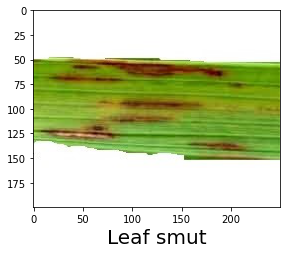

In [35]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0512.jpg'
path = 'Rice Leaf Disease/Leaf_smut/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

Text(0.5, 0, 'Brown spot')

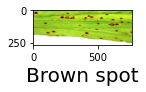

In [36]:
# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0108.jpg'
path = 'Rice Leaf Disease/Brown_Spot/Brown Spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

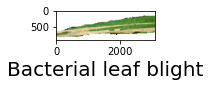

In [37]:
# Image 3
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0702.jpg'
path = 'Rice Leaf Disease/Bacterial_leaf/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()

In [38]:
import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix

In [39]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])

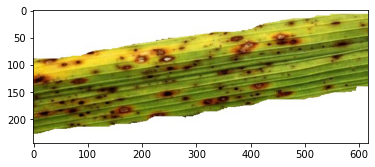

In [40]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

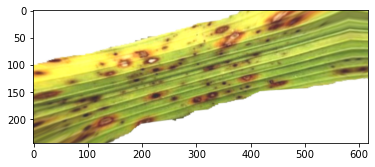

In [41]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

# Train Generator

In [42]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0389.JPG,1,0,0
16,DSC_0308.JPG,0,0,1
17,DSC_0365.JPG,1,0,0
18,DSC_0377.JPG,1,0,0
19,DSC_0509.jpg,0,0,1


In [43]:
def train_generator(batch_size=8):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train) 

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
              
            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                          
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train


In [44]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [45]:
y_train

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int64)

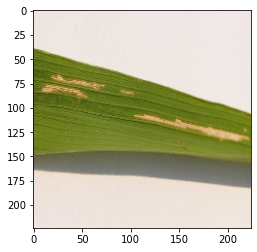

In [46]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

# Val Generator

In [47]:
def val_generator(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_val
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image
                
                
            
            
            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
            
                
                          
                
            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [48]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [49]:
y_val

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int64)

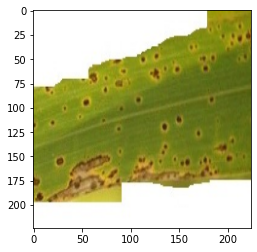

In [50]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

# Test Generator

In [51]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_test
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image
                
                 
                
            # Normalize the images
            X_test = X_test/255

            yield X_test

In [52]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


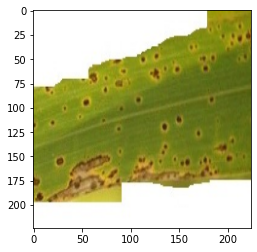

In [53]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

# Model Architecture

In [54]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

In [55]:
from tensorflow.keras.applications.mobilenet import MobileNet
model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Train the Model

In [56]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [64]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=100, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)


Epoch 1/100
13/13 [==============================] - 20s 1s/step - loss: 0.0308 - accuracy: 0.9986 - val_loss: 0.8596 - val_accuracy: 0.8000

Epoch 00001: val_accuracy improved from -inf to 0.80000, saving model to model.h5
Epoch 2/100
13/13 [==============================] - 18s 1s/step - loss: 0.2107 - accuracy: 0.9092 - val_loss: 0.5157 - val_accuracy: 0.8000

Epoch 00002: val_accuracy did not improve from 0.80000
Epoch 3/100
13/13 [==============================] - 17s 1s/step - loss: 0.1765 - accuracy: 0.9186 - val_loss: 0.0489 - val_accuracy: 0.9333

Epoch 00003: val_accuracy improved from 0.80000 to 0.93333, saving model to model.h5
Epoch 4/100
13/13 [==============================] - 18s 1s/step - loss: 0.4993 - accuracy: 0.9129 - val_loss: 0.0322 - val_accuracy: 1.0000

Epoch 00004: val_accuracy improved from 0.93333 to 1.00000, saving model to model.h5
Epoch 5/100
13/13 [==============================] - 18s 1s/step - loss: 0.0653 - accuracy: 0.9752 - val_loss: 0.2189 - val_a

13/13 [==============================] - 18s 1s/step - loss: 0.1845 - accuracy: 0.9651 - val_loss: 0.7504 - val_accuracy: 0.8667

Epoch 00042: val_accuracy did not improve from 1.00000
Epoch 43/100
13/13 [==============================] - 19s 1s/step - loss: 0.0570 - accuracy: 0.9756 - val_loss: 0.7461 - val_accuracy: 0.8667

Epoch 00043: val_accuracy did not improve from 1.00000
Epoch 44/100
13/13 [==============================] - 19s 1s/step - loss: 3.1150e-04 - accuracy: 1.0000 - val_loss: 0.7369 - val_accuracy: 0.8667

Epoch 00044: val_accuracy did not improve from 1.00000
Epoch 45/100
13/13 [==============================] - 19s 1s/step - loss: 0.0704 - accuracy: 0.9807 - val_loss: 0.6784 - val_accuracy: 0.8667

Epoch 00045: val_accuracy did not improve from 1.00000
Epoch 46/100
13/13 [==============================] - 20s 2s/step - loss: 9.8423e-04 - accuracy: 1.0000 - val_loss: 0.7773 - val_accuracy: 0.8667

Epoch 00046: val_accuracy did not improve from 1.00000
Epoch 47/100
13

In [65]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.990385,0.049099,0.800000,0.859556
1,1,0.932692,0.248096,0.800000,0.515667
2,2,0.923077,0.142184,0.933333,0.048928
3,3,0.951923,0.199586,1.000000,0.032240
4,4,0.951923,0.127760,0.933333,0.218871


## Evaluate the model on the val set

In [66]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [67]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\Asus\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.032240014523267746
val_acc: 1.0


# Plot the training curves

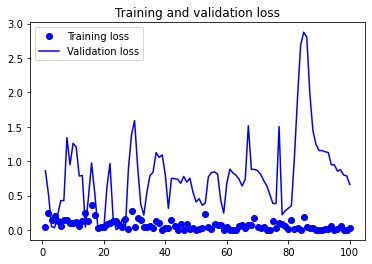

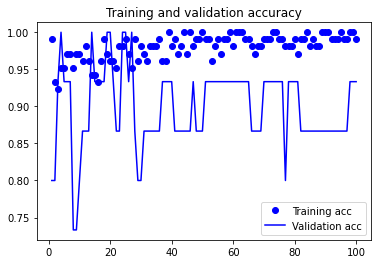

<Figure size 432x288 with 0 Axes>

In [68]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## Make a prediction on the val set

In [69]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

C:\Users\Asus\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


15/15 [==============================] - 1s 49ms/step


In [70]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

y_pred

array([1, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1], dtype=int64)

In [71]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

array([1, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1], dtype=int64)

In [72]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

[1 0 2 1 0 2 2 0 0 0 2 1 1 2 1]
[1 0 2 1 0 2 2 0 0 0 2 1 1 2 1]


## Confusion Matrix

In [73]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[5 0 0]
 [0 5 0]
 [0 0 5]]


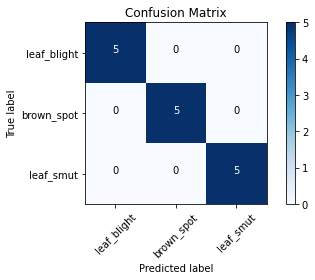

In [74]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [75]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00         5
           brown_spot       1.00      1.00      1.00         5
            leaf_smut       1.00      1.00      1.00         5

             accuracy                           1.00        15
            macro avg       1.00      1.00      1.00        15
         weighted avg       1.00      1.00      1.00        15



Conclusion: The model is overfit but it's ok to be overfit in image classification problems